1. Selección del modelo


### Justificación:
- ResNet50 es conocido por su capacidad de manejar redes profundas sin problemas de degradación.
- VGG16 es simple y efectivo, con un buen equilibrio entre profundidad y rendimiento.

2. Preprocesamiento de imágenes y data augmentation
- [ImagePreparation.ipynb](ImagePreparation.ipynb)

In [1]:
from torchvision import models

# Selección de modelos
model1 = models.resnet50(pretrained=True)
model2 = models.vgg16(pretrained=True)



c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 30.9MB/s]
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: User

cuda:0
Training resnet on bilateral dataset
Epoch 0/24
----------
train Loss: 0.5609 Acc: 0.7869
val Loss: 17.7535 Acc: 0.5832
Epoch 1/24
----------
train Loss: 0.3711 Acc: 0.8629
val Loss: 19.2804 Acc: 0.5937
Epoch 2/24
----------
train Loss: 0.3083 Acc: 0.8947
val Loss: 21.1936 Acc: 0.5998
Epoch 3/24
----------
train Loss: 0.2896 Acc: 0.9008
val Loss: 21.1809 Acc: 0.5970
Epoch 4/24
----------
train Loss: 0.2573 Acc: 0.9137
val Loss: 19.8033 Acc: 0.5970
Epoch 5/24
----------
train Loss: 0.2462 Acc: 0.9186
val Loss: 25.0300 Acc: 0.6053
Epoch 6/24
----------
train Loss: 0.2490 Acc: 0.9157
val Loss: 29.0384 Acc: 0.6070
Epoch 7/24
----------
train Loss: 0.2249 Acc: 0.9238
val Loss: 27.8277 Acc: 0.6036
Epoch 8/24
----------
train Loss: 0.2287 Acc: 0.9215
val Loss: 26.3701 Acc: 0.6086
Epoch 9/24
----------
train Loss: 0.2149 Acc: 0.9256
val Loss: 25.8761 Acc: 0.6059
Epoch 10/24
----------
train Loss: 0.2143 Acc: 0.9256
val Loss: 28.4465 Acc: 0.6125
Epoch 11/24
----------
train Loss: 0.1995 

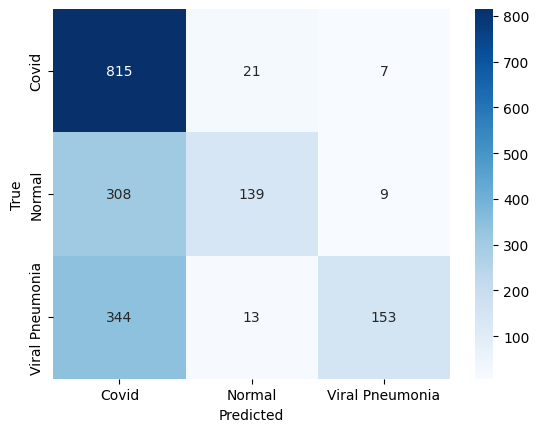

Training resnet on raw dataset
Epoch 0/24
----------
train Loss: 0.1717 Acc: 0.9375
val Loss: 31.7627 Acc: 0.6180
Epoch 1/24
----------
train Loss: 0.1711 Acc: 0.9402
val Loss: 33.8889 Acc: 0.6119
Epoch 2/24
----------
train Loss: 0.1562 Acc: 0.9476
val Loss: 28.7166 Acc: 0.6114
Epoch 3/24
----------
train Loss: 0.1573 Acc: 0.9481
val Loss: 29.5621 Acc: 0.6153
Epoch 4/24
----------
train Loss: 0.1572 Acc: 0.9476
val Loss: 33.8599 Acc: 0.6180
Epoch 5/24
----------
train Loss: 0.1611 Acc: 0.9429
val Loss: 34.2778 Acc: 0.6186
Epoch 6/24
----------
train Loss: 0.1514 Acc: 0.9466
val Loss: 33.7717 Acc: 0.6175
Epoch 7/24
----------
train Loss: 0.1549 Acc: 0.9469
val Loss: 33.8578 Acc: 0.6175
Epoch 8/24
----------
train Loss: 0.1522 Acc: 0.9489
val Loss: 33.4988 Acc: 0.6169
Epoch 9/24
----------
train Loss: 0.1526 Acc: 0.9488
val Loss: 35.3965 Acc: 0.6175
Epoch 10/24
----------
train Loss: 0.1412 Acc: 0.9545
val Loss: 29.8908 Acc: 0.6180
Epoch 11/24
----------
train Loss: 0.1487 Acc: 0.9502
v

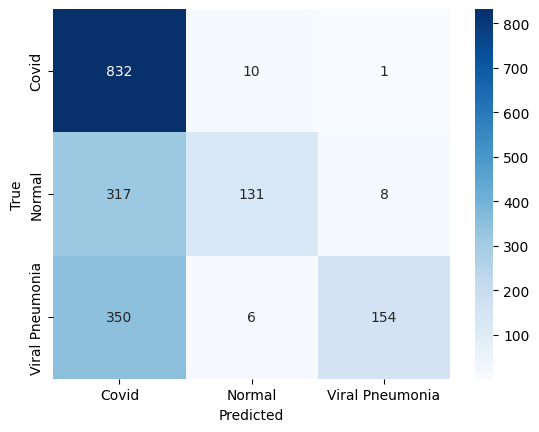

Training resnet on canny dataset
Epoch 0/24
----------
train Loss: 0.1367 Acc: 0.9528
val Loss: 37.2401 Acc: 0.6208
Epoch 1/24
----------
train Loss: 0.1319 Acc: 0.9556
val Loss: 36.2466 Acc: 0.6197
Epoch 2/24
----------
train Loss: 0.1295 Acc: 0.9557
val Loss: 34.6881 Acc: 0.6235
Epoch 3/24
----------
train Loss: 0.1291 Acc: 0.9592
val Loss: 38.4251 Acc: 0.6191
Epoch 4/24
----------
train Loss: 0.1309 Acc: 0.9568
val Loss: 38.6898 Acc: 0.6208
Epoch 5/24
----------
train Loss: 0.1247 Acc: 0.9604
val Loss: 37.6384 Acc: 0.6213
Epoch 6/24
----------
train Loss: 0.1256 Acc: 0.9614
val Loss: 34.3472 Acc: 0.6219
Epoch 7/24
----------
train Loss: 0.1291 Acc: 0.9577
val Loss: 39.9702 Acc: 0.6202
Epoch 8/24
----------
train Loss: 0.1367 Acc: 0.9521
val Loss: 35.5762 Acc: 0.6208
Epoch 9/24
----------
train Loss: 0.1300 Acc: 0.9566
val Loss: 34.9965 Acc: 0.6208
Epoch 10/24
----------
train Loss: 0.1231 Acc: 0.9581
val Loss: 34.7449 Acc: 0.6208
Epoch 11/24
----------
train Loss: 0.1230 Acc: 0.9608

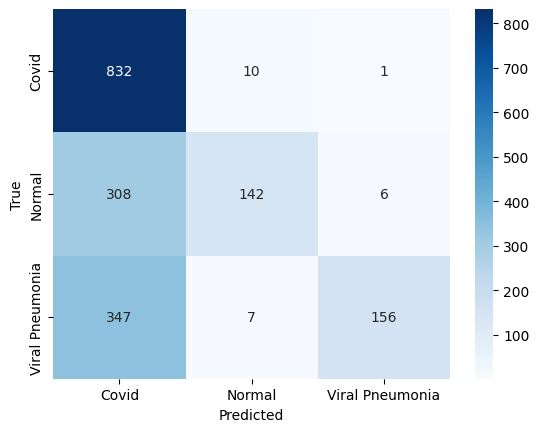

Training vgg on bilateral dataset
Epoch 0/24
----------
train Loss: 0.5041 Acc: 0.7930
val Loss: 0.3925 Acc: 0.8347
Epoch 1/24
----------
train Loss: 0.3718 Acc: 0.8561
val Loss: 0.4043 Acc: 0.8369
Epoch 2/24
----------
train Loss: 0.3479 Acc: 0.8620
val Loss: 0.2261 Acc: 0.9132
Epoch 3/24
----------
train Loss: 0.3069 Acc: 0.8822
val Loss: 0.2970 Acc: 0.8789
Epoch 4/24
----------
train Loss: 0.3025 Acc: 0.8842
val Loss: 0.2146 Acc: 0.9243
Epoch 5/24
----------
train Loss: 0.2892 Acc: 0.8858
val Loss: 0.2109 Acc: 0.9254
Epoch 6/24
----------
train Loss: 0.2821 Acc: 0.8905
val Loss: 0.2224 Acc: 0.9232
Epoch 7/24
----------
train Loss: 0.2782 Acc: 0.8932
val Loss: 0.2110 Acc: 0.9254
Epoch 8/24
----------
train Loss: 0.2874 Acc: 0.8871
val Loss: 0.1943 Acc: 0.9303
Epoch 9/24
----------
train Loss: 0.2685 Acc: 0.9000
val Loss: 0.2311 Acc: 0.9038
Epoch 10/24
----------
train Loss: 0.2615 Acc: 0.8993
val Loss: 0.1991 Acc: 0.9276
Epoch 11/24
----------
train Loss: 0.2550 Acc: 0.9008
val Loss:

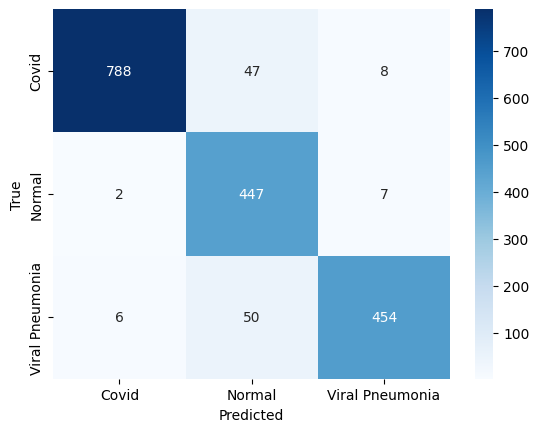

Training vgg on raw dataset
Epoch 0/24
----------
train Loss: 0.2360 Acc: 0.9051
val Loss: 0.2010 Acc: 0.9193
Epoch 1/24
----------
train Loss: 0.2288 Acc: 0.9077
val Loss: 0.1920 Acc: 0.9248
Epoch 2/24
----------
train Loss: 0.2348 Acc: 0.9085
val Loss: 0.1575 Acc: 0.9403
Epoch 3/24
----------
train Loss: 0.2278 Acc: 0.9110
val Loss: 0.2432 Acc: 0.8999
Epoch 4/24
----------
train Loss: 0.2451 Acc: 0.9065
val Loss: 0.2119 Acc: 0.9160
Epoch 5/24
----------
train Loss: 0.2299 Acc: 0.9138
val Loss: 0.1654 Acc: 0.9370
Epoch 6/24
----------
train Loss: 0.2228 Acc: 0.9131
val Loss: 0.1596 Acc: 0.9348
Epoch 7/24
----------
train Loss: 0.2313 Acc: 0.9084
val Loss: 0.1882 Acc: 0.9248
Epoch 8/24
----------
train Loss: 0.2336 Acc: 0.9098
val Loss: 0.1654 Acc: 0.9364
Epoch 9/24
----------
train Loss: 0.2290 Acc: 0.9137
val Loss: 0.1615 Acc: 0.9375
Epoch 10/24
----------
train Loss: 0.2292 Acc: 0.9123
val Loss: 0.2145 Acc: 0.9149
Epoch 11/24
----------
train Loss: 0.2184 Acc: 0.9173
val Loss: 0.137

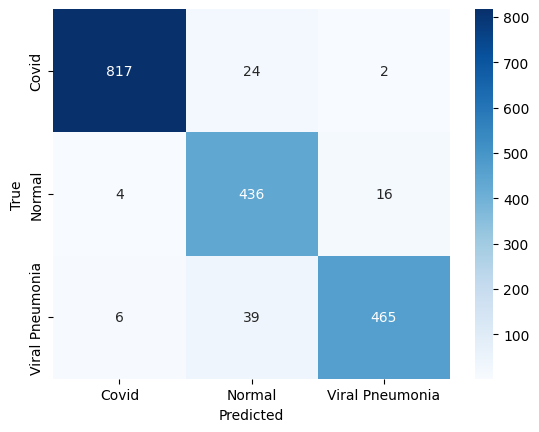

Training vgg on canny dataset
Epoch 0/24
----------
train Loss: 0.2141 Acc: 0.9171
val Loss: 0.1731 Acc: 0.9315
Epoch 1/24
----------
train Loss: 0.2183 Acc: 0.9177
val Loss: 0.1691 Acc: 0.9364
Epoch 2/24
----------
train Loss: 0.2216 Acc: 0.9135
val Loss: 0.1382 Acc: 0.9514
Epoch 3/24
----------
train Loss: 0.2132 Acc: 0.9209
val Loss: 0.1598 Acc: 0.9337
Epoch 4/24
----------
train Loss: 0.2237 Acc: 0.9166
val Loss: 0.1357 Acc: 0.9475
Epoch 5/24
----------
train Loss: 0.2203 Acc: 0.9175
val Loss: 0.1699 Acc: 0.9348
Epoch 6/24
----------
train Loss: 0.2105 Acc: 0.9203
val Loss: 0.1395 Acc: 0.9508
Epoch 7/24
----------
train Loss: 0.2192 Acc: 0.9163
val Loss: 0.1731 Acc: 0.9337
Epoch 8/24
----------
train Loss: 0.2009 Acc: 0.9202
val Loss: 0.1723 Acc: 0.9348
Epoch 9/24
----------
train Loss: 0.2178 Acc: 0.9166
val Loss: 0.1264 Acc: 0.9541
Epoch 10/24
----------
train Loss: 0.2208 Acc: 0.9167
val Loss: 0.1487 Acc: 0.9414
Epoch 11/24
----------
train Loss: 0.2041 Acc: 0.9258
val Loss: 0.1

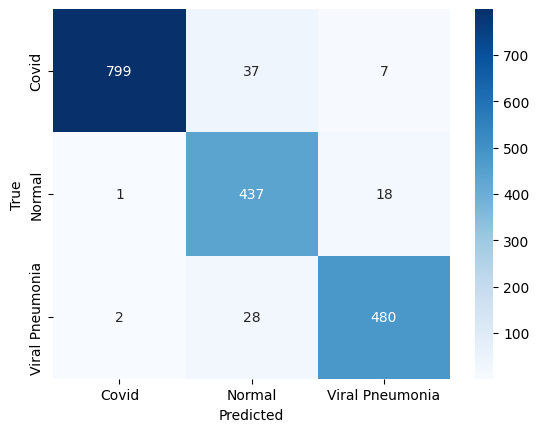

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir transformaciones para los datos
data_transforms = {
    'bilateral': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'raw': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'canny': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Cargar los datos
data_dir = 'dataset/augmented'
image_datasets = {x: datasets.ImageFolder(f'{data_dir}/{x}', data_transforms[x]) for x in ['bilateral', 'raw', 'canny']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['bilateral', 'raw', 'canny']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['bilateral', 'raw', 'canny']}
class_names = image_datasets['raw'].classes


# Función para entrenar el modelo
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for dataset in ['bilateral', 'raw', 'canny']:
                for inputs, labels in dataloaders[phase][dataset]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / sum(dataset_sizes[phase].values())
            epoch_acc = running_corrects.double() / sum(dataset_sizes[phase].values())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


# Función para evaluar el modelo
def evaluate_model(model, dataloaders, dataset_sizes):
    model.eval()
    all_preds = []
    all_labels = []

    for dataset in ['bilateral', 'raw', 'canny']:
        for inputs, labels in dataloaders['val'][dataset]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Configuración del dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Split the datasets into training and validation sets
train_datasets = {}
val_datasets = {}
for x in ['bilateral', 'raw', 'canny']:
    train_idx, val_idx = train_test_split(list(range(len(image_datasets[x]))), test_size=0.2, random_state=42)
    train_datasets[x] = torch.utils.data.Subset(image_datasets[x], train_idx)
    val_datasets[x] = torch.utils.data.Subset(image_datasets[x], val_idx)

# Update the dataloaders dictionary
dataloaders = {
    'train': {x: torch.utils.data.DataLoader(train_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['bilateral', 'raw', 'canny']},
    'val': {x: torch.utils.data.DataLoader(val_datasets[x], batch_size=32, shuffle=False, num_workers=4) for x in ['bilateral', 'raw', 'canny']}
}

dataset_sizes = {
    'train': {x: len(train_datasets[x]) for x in ['bilateral', 'raw', 'canny']},
    'val': {x: len(val_datasets[x]) for x in ['bilateral', 'raw', 'canny']}
}

# Definir los modelos a entrenar
models_to_train = {
    'resnet': models.resnet50(pretrained=True),
    'vgg': models.vgg16(pretrained=True)
}

for model_name, model in models_to_train.items():
    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'resnet':
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    elif model_name == 'vgg':
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters() if model_name == 'resnet' else model.classifier[6].parameters(), lr=0.001, momentum=0.9)

    for dataset in ['bilateral', 'raw', 'canny']:
        print(f'Training {model_name} on {dataset} dataset')
        model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes)
        torch.save(model.state_dict(), f'{model_name}_{dataset}.pth')
        evaluate_model(model, dataloaders, dataset_sizes)

In [ ]:
## Evaluar Modelo
for dataset in ['bilateral', 'raw', 'canny']:
    print(f'Evaluating {model_name} on {dataset} dataset')
    evaluate_model(model, dataloaders, dataset_sizes)


# Cargar y ajustar los modelos
models_to_train = {
    'resnet': models.resnet18(pretrained=True),
    'vgg': models.vgg16(pretrained=True)
}

for model_name, model in models_to_train.items():
    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'resnet':
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    elif model_name == 'vgg':
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters() if model_name == 'resnet' else model.classifier[6].parameters(), lr=0.001, momentum=0.9)

    for dataset in ['bilateral', 'raw', 'canny']:
        print(f'Training {model_name} on {dataset} dataset')
        model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes)
        torch.save(model.state_dict(), f'{model_name}_{dataset}.pth')
        evaluate_model(model, dataloaders, dataset_sizes)

Evaluating vgg on bilateral dataset


KeyboardInterrupt: 

## Weights and Biases

In [9]:
import sys
print(sys.executable)
!{sys.executable} -m pip install wandb
!{sys.executable} -m pip install tensorflow

c:\Users\Administrator\Documents\Covid\.venv\Scripts\python.exe
  Using cached tensorflow-2.18.0-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.0-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.68.1-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using 

  You can safely remove it manually.
  You can safely remove it manually.


In [15]:
import sys
print(sys.executable)

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn

c:\Users\Administrator\Documents\Covid\.venv\Scripts\python.exe


In [ ]:
import wandb
import tensorflow as tf
import numpy as np

# Inicializa W&B
wandb.init(project="covid")

# Configura los hiperparámetros
config = wandb.config
config.learning_rate = 0.001
config.epochs = 10
config.batch_size = 32

# Define tu modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compila el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(config.learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define los callbacks de W&B
callbacks = [wandb.keras.WandbCallback()]

# Entrena el modelo
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=config.epochs,
          batch_size=config.batch_size,
          callbacks=callbacks)

# Finaliza el run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

## Silency Maps

In [9]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from PIL import Image

# Load the pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Function to preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)
    return image

# Function to show the image
def show_image(image_tensor):
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    return image

# Directories
input_folder = 'dataset/augmented'
output_folder = 'dataset/silency_maps'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process all images in the bilateral, canny, and raw folders
for subfolder in ['bilateral', 'canny', 'raw']:
    subfolder_path = os.path.join(input_folder, subfolder)
    for class_folder in ['covid', 'normal', 'pneumonia']:
        class_folder_path = os.path.join(subfolder_path, class_folder)
        if not os.path.exists(class_folder_path):
            print(f"Directory does not exist: {class_folder_path}")
            continue  # Skip processing this directory
        for filename in os.listdir(class_folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_folder_path, filename)
                input_image = preprocess_image(image_path)

                # Generate saliency map
                input_image.requires_grad_()
                output = model(input_image)
                output_idx = output.argmax()
                output_max = output[0, output_idx]

                model.zero_grad()
                output_max.backward()

                saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
                saliency = saliency.squeeze().cpu().detach().numpy()

                # Save the saliency map
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(show_image(input_image))
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(saliency, cmap='hot')
                plt.title('Silency Map')
                plt.axis('off')

                output_subfolder = os.path.join(output_folder, subfolder, class_folder)
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                output_path = os.path.join(output_subfolder, f'saliency_{filename}')
                plt.savefig(output_path)
                plt.close()

c:\Users\Administrator\Documents\Covid\.covid\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\Covid\.covid\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
